<a href="https://colab.research.google.com/github/ssungg/AI-and-Information-Security/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##전처리

초기 데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257672 entries, 0 to 257671
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257672 non-null  int64  
 1   dur                257672 non-null  float64
 2   proto              257672 non-null  object 
 3   service            257672 non-null  object 
 4   state              257672 non-null  object 
 5   spkts              257672 non-null  int64  
 6   dpkts              257672 non-null  int64  
 7   sbytes             257672 non-null  int64  
 8   dbytes             257672 non-null  int64  
 9   rate               257672 non-null  float64
 10  sttl               257672 non-null  int64  
 11  dttl               257672 non-null  int64  
 12  sload              257672 non-null  float64
 13  dload              257672 non-null  float64
 14  sloss              257672 non-null  int64  
 15  dloss              257672 non-null  int6

<ipython-input-3-80d3c13b2c5f>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['service'].replace('-', np.nan, inplace=True)


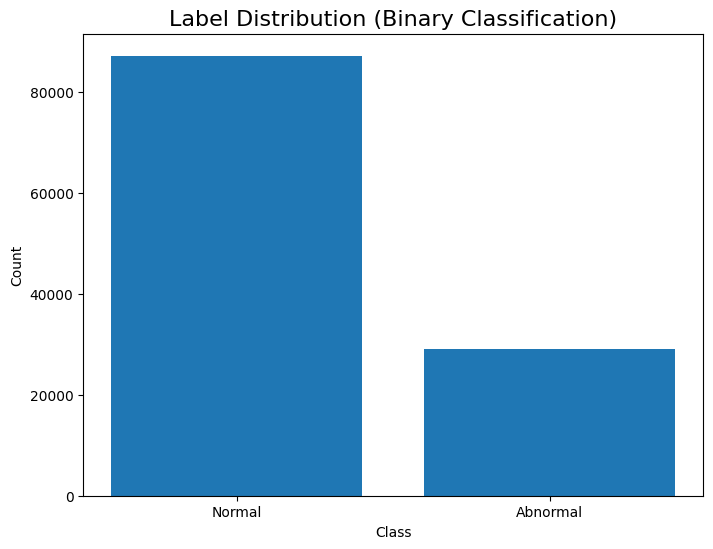

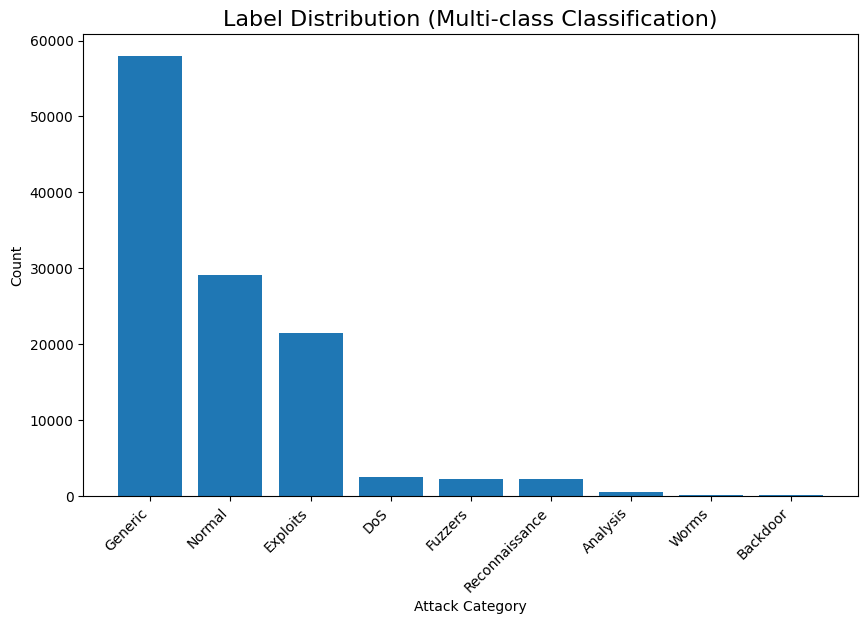

이중분류 - 훈련 데이터 크기: (93081, 56)
다중분류 - 훈련 데이터 크기: (93081, 56)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. 데이터셋 로드
data = pd.read_csv('/content/drive/MyDrive/인공지능과 정보보호/1206/UNSW-NB15_training_testing.csv')

# 2. 데이터셋 초기 확인
print("초기 데이터 정보:")
data.info()
print("초기 데이터 크기:", data.shape)

# 3. 불필요한 컬럼 제거
data.drop(['id'], axis=1, inplace=True)

# 4. 결측값 처리
data['service'].replace('-', np.nan, inplace=True)
data.dropna(inplace=True)

# 5. UNSW-NB15_features.csv 파일 로드 및 타입별 데이터 컬럼 분류
import chardet
with open('/content/drive/MyDrive/인공지능과 정보보호/NUSW-NB15_features.csv', 'rb') as file:
    result = chardet.detect(file.read())

features = pd.read_csv('/content/drive/MyDrive/인공지능과 정보보호/NUSW-NB15_features.csv', encoding=result['encoding'])
features['Type '] = features['Type '].str.lower()

# 데이터 타입별 컬럼 분류
nominal_names = features['Name'][features['Type '] == 'nominal']
integer_names = features['Name'][features['Type '] == 'integer']
binary_names = features['Name'][features['Type '] == 'binary']
float_names = features['Name'][features['Type '] == 'float']

# 데이터셋의 유효한 컬럼만 선택
cols = data.columns
nominal_names = cols.intersection(nominal_names)
integer_names = cols.intersection(integer_names)
binary_names = cols.intersection(binary_names)
float_names = cols.intersection(float_names)

# 데이터 타입 변환
for c in integer_names.union(binary_names).union(float_names):
    data[c] = pd.to_numeric(data[c])

# 6. 데이터 시각화 (라벨 분포)
plt.figure(figsize=(8, 6))
binary_counts = data['label'].value_counts()
binary_labels = ['Normal', 'Abnormal']
plt.bar(binary_labels, binary_counts)
plt.title("Label Distribution (Binary Classification)", fontsize=16)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=range(len(binary_labels)), labels=binary_labels)
plt.show()

plt.figure(figsize=(10, 6))
multi_counts = data['attack_cat'].value_counts()
plt.bar(multi_counts.index, multi_counts.values,)
plt.title("Label Distribution (Multi-class Classification)", fontsize=16)
plt.xlabel("Attack Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

# 7. 원-핫 인코딩 (범주형 데이터)
cat_col = data.select_dtypes(include='object').columns.difference(['attack_cat'])
data = pd.get_dummies(data, columns=cat_col, drop_first=True)

# 8. 정규화 (숫자형 데이터)
num_col = data.select_dtypes(include='number').columns.difference(['label', 'attack_cat_encoded'])
scaler = StandardScaler()
data[num_col] = scaler.fit_transform(data[num_col])

# 9. 타겟 인코딩
# 다중분류 타겟 (attack_cat)
label_encoder = LabelEncoder()
data['attack_cat_encoded'] = label_encoder.fit_transform(data['attack_cat'])

# 이진분류 타겟 (label: 정상, 비정상)
y_binary = data['label']

# 다중분류 타겟 (attack_cat_encoded)
y_multi = data['attack_cat_encoded']

# 입력 데이터에서 타겟 제거
X = data.drop(['label', 'attack_cat', 'attack_cat_encoded'], axis=1)

# 10. 데이터 분할
# 이중분류 데이터 분할
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# 다중분류 데이터 분할
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# 데이터 크기 확인
print("이중분류 - 훈련 데이터 크기:", X_train_binary.shape)
print("다중분류 - 훈련 데이터 크기:", X_train_multi.shape)


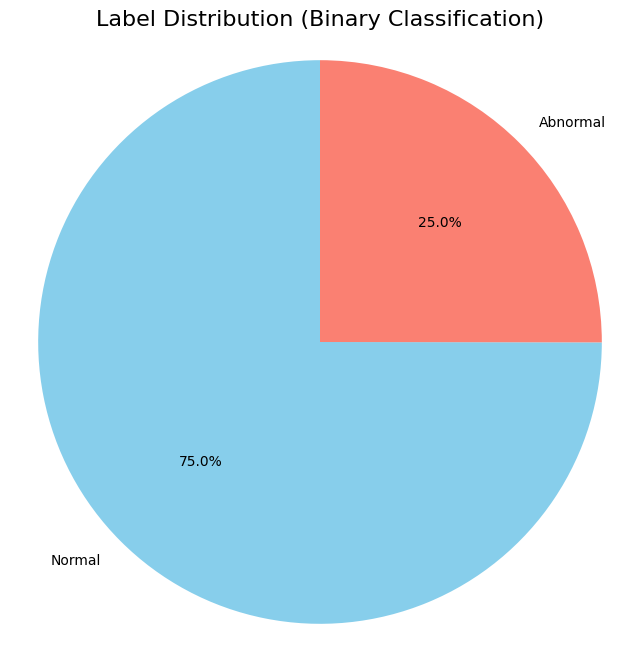

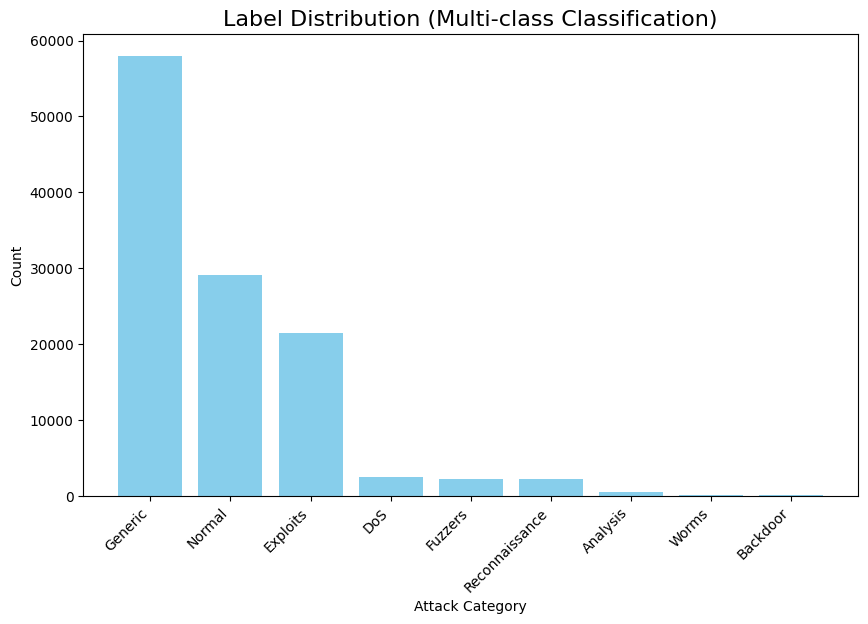

In [ ]:
# 원 그래프 시각화
plt.figure(figsize=(8, 8))
binary_counts = data['label'].value_counts()
binary_labels = ['Normal', 'Abnormal']
plt.pie(binary_counts, labels=binary_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title("Label Distribution (Binary Classification)", fontsize=16)
plt.axis('equal')  # 원형 유지
plt.show()

plt.figure(figsize=(10, 6))
multi_counts = data['attack_cat'].value_counts()
plt.bar(multi_counts.index, multi_counts.values, color='skyblue')
plt.title("Label Distribution (Multi-class Classification)", fontsize=16)
plt.xlabel("Attack Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# 다중분류에서 Normal 클래스 제거
data_multi = data[data['attack_cat'] != 'Normal']

# 다시 다중분류 타겟 인코딩
data_multi['attack_cat_encoded'] = label_encoder.fit_transform(data_multi['attack_cat'])

# 다중분류 타겟 (attack_cat_encoded)
y_multi = data_multi['attack_cat_encoded']

# 입력 데이터에서 타겟 제거
X_multi = data_multi.drop(['label', 'attack_cat', 'attack_cat_encoded'], axis=1)

# 다중분류 데이터 분할
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42
)

# 데이터 크기 및 분포 확인
print("다중분류 (Normal 제거) - 훈련 데이터 크기:", X_train_multi.shape)
print("다중분류 (Normal 제거) - 테스트 데이터 크기:", X_test_multi.shape)
print("\n다중분류 라벨 분포 (훈련 데이터):")
print(y_train_multi.value_counts())
print("\n다중분류 라벨 분포 (테스트 데이터):")
print(y_test_multi.value_counts())


<ipython-input-5-961b2a08da79>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_multi['attack_cat_encoded'] = label_encoder.fit_transform(data_multi['attack_cat'])


다중분류 (Normal 제거) - 훈련 데이터 크기: (69791, 56)
다중분류 (Normal 제거) - 테스트 데이터 크기: (17448, 56)

다중분류 라벨 분포 (훈련 데이터):
attack_cat_encoded
5    46365
3    17184
2     2006
4     1813
6     1766
0      451
7      118
1       88
Name: count, dtype: int64

다중분류 라벨 분포 (테스트 데이터):
attack_cat_encoded
5    11591
3     4296
2      502
4      453
6      441
0      113
7       30
1       22
Name: count, dtype: int64


In [ ]:
# LabelEncoder로 인코딩된 클래스 이름 확인
class_mapping = dict(enumerate(label_encoder.classes_))
print("Encoded Class Mapping:")
for encoded_label, class_name in class_mapping.items():
    print(f"{encoded_label}: {class_name}")

Encoded Class Mapping:
0: Analysis
1: Backdoor
2: DoS
3: Exploits
4: Fuzzers
5: Generic
6: Reconnaissance
7: Worms


##결정트리

In [ ]:
# 성능 기록을 위한 데이터프레임 생성
performance_data = []

###1.기본

Performance Metrics:
Accuracy: 0.9806
Recall: 0.9874
Precision: 0.9868
F1-Score: 0.9871
Time to Train: 2.2889 seconds
Time to Predict: 0.0134 seconds

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



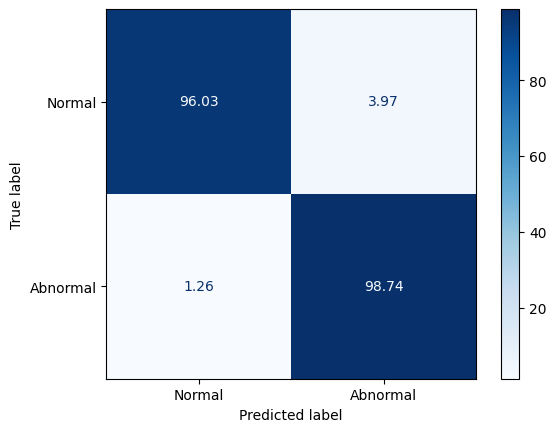

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 1. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 4. 성능 기록
performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Performance Metrics (Decision Tree - Multi-class):
Accuracy: 0.9307
Recall: 0.9307
Precision: 0.9324
F1-Score: 0.9315
Time to Train: 2.4735 seconds
Time to Predict: 0.0411 seconds

Classification Report (Decision Tree - Multi-class):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       113
           1       0.48      0.45      0.47        22
           2       0.43      0.45      0.44       502
           3       0.88      0.86      0.87      4296
           4       0.94      0.92      0.93       453
           5       0.99      1.00      1.00     11591
           6       0.49      0.54      0.51       441
           7       0.47      0.47      0.47        30

    accuracy                           0.93     17448
   macro avg       0.68      0.68      0.68     17448
weighted avg       0.93      0.93      0.93     17448



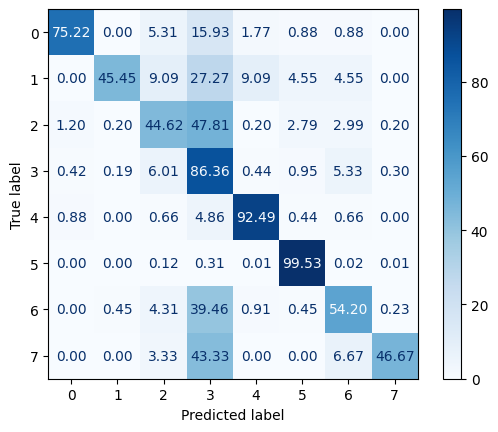

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 성능 기록용 리스트
performance_data = []

# 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 1. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 4. 성능 기록
performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics (Decision Tree - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report (Decision Tree - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###2. 특성 추출

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Performance Metrics (Decision Tree with Feature Selection - Binary Classification):
Accuracy: 0.9774
Recall: 0.9858
Precision: 0.9842
F1-Score: 0.9850
Time to Train: 0.5675 seconds
Time to Predict: 0.0044 seconds

Classification Report (Decision Tree with Feature Selection - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.95      0.95      5823
    Abnormal       0.98      0.99      0.98     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



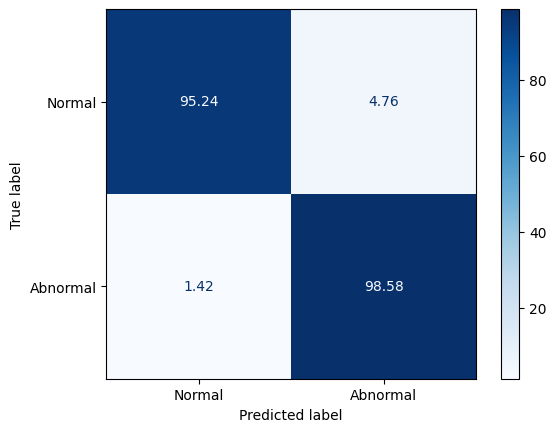

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_binary_reduced = selector.fit_transform(X_train_binary, y_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

# 2. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_reduced, y_train_binary)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Selection - Binary Classification):
Accuracy: 0.9797
Recall: 0.9873
Precision: 0.9856
F1-Score: 0.9865
Time to Train: 2.8426 seconds
Time to Predict: 0.0093 seconds

Classification Report (Decision Tree with Feature Selection - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



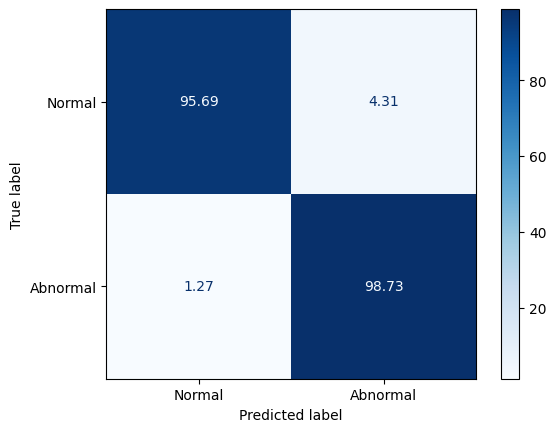

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 선택 (결정트리 특성 중요도 기반)
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_binary, y_train_binary)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_binary_reduced = selector.transform(X_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_reduced, y_train_binary)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

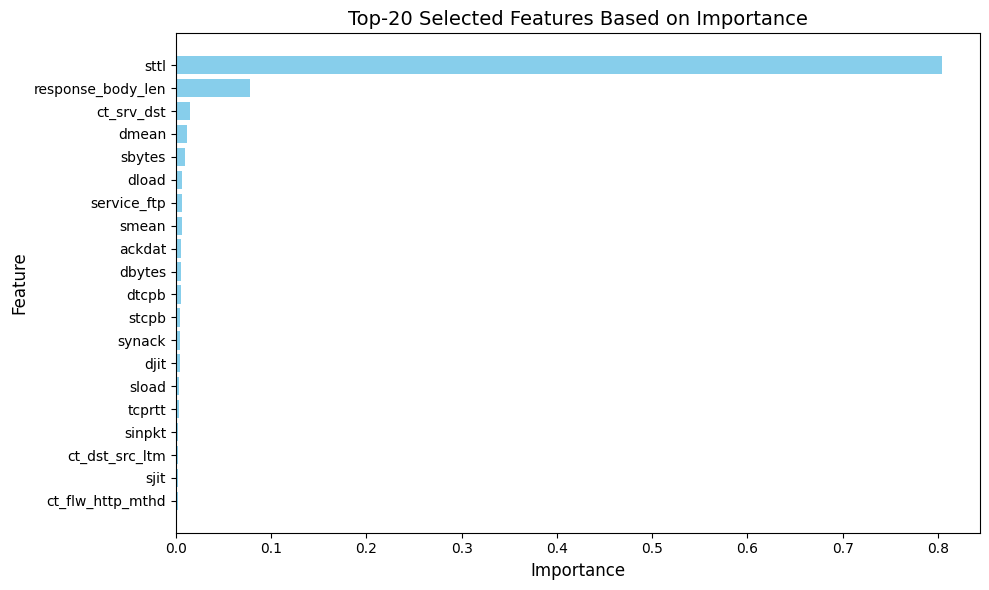

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 선택된 특징의 인덱스와 이름
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_binary.columns[selected_feature_indices]

# 선택된 특징의 중요도 추출
selected_feature_importances = importances[selected_feature_indices]

# 데이터프레임 생성 (이름과 중요도)
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_feature_importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.title('Top-20 Selected Features Based on Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Performance Metrics (Decision Tree with Feature Selection - Multi-class):
Accuracy: 0.8873
Recall: 0.8873
Precision: 0.8895
F1-Score: 0.8884
Time to Train: 1.5196 seconds
Time to Predict: 0.0106 seconds

Classification Report (Decision Tree with Feature Selection - Multi-class):
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       113
           1       0.00      0.00      0.00        22
           2       0.19      0.21      0.20       502
           3       0.82      0.80      0.81      4296
           4       0.68      0.68      0.68       453
           5       0.99      0.99      0.99     11591
           6       0.24      0.24      0.24       441
           7       0.00      0.00      0.00        30

    accuracy                           0.89     17448
   macro avg       0.44      0.44      0.44     17448
weighted avg       0.89      0.89      0.89     17448



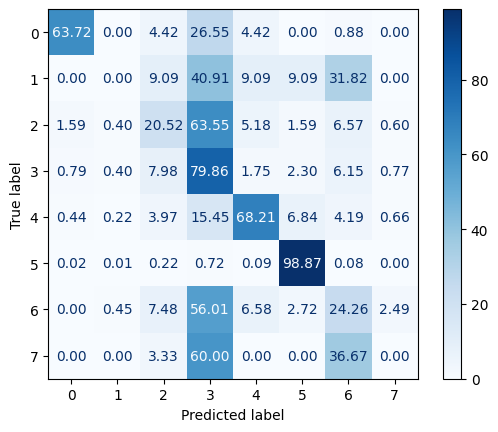

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_reduced, y_train_multi)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Selection - Multi-class):
Accuracy: 0.9297
Recall: 0.9297
Precision: 0.9312
F1-Score: 0.9304
Time to Train: 2.0496 seconds
Time to Predict: 0.0042 seconds

Classification Report (Decision Tree with Feature Selection - Multi-class):
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       113
           1       0.39      0.50      0.44        22
           2       0.44      0.47      0.46       502
           3       0.88      0.86      0.87      4296
           4       0.91      0.92      0.92       453
           5       0.99      1.00      0.99     11591
           6       0.48      0.51      0.49       441
           7       0.46      0.43      0.45        30

    accuracy                           0.93     17448
   macro avg       0.66      0.68      0.67     17448
weighted avg       0.93      0.93      0.93     17448



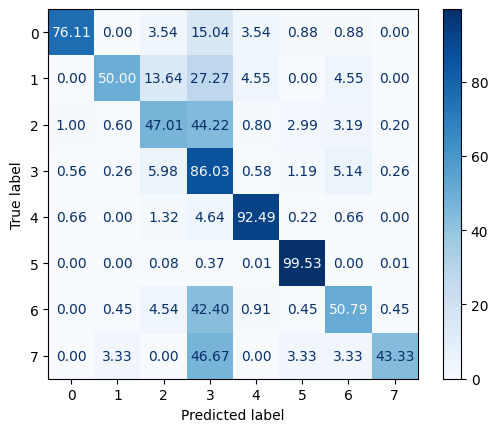

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_multi, y_train_multi)
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_multi_reduced = selector.transform(X_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_reduced, y_train_multi)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "Decision Tree",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


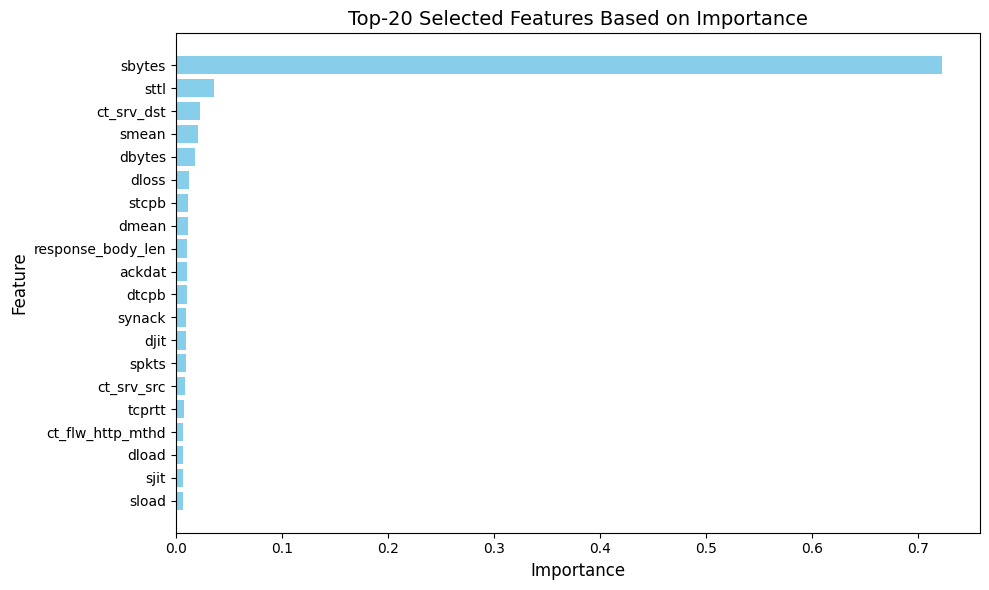

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 선택된 특징의 인덱스와 이름
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_binary.columns[selected_feature_indices]

# 선택된 특징의 중요도 추출
selected_feature_importances = importances[selected_feature_indices]

# 데이터프레임 생성 (이름과 중요도)
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': selected_feature_importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 정렬
plt.title('Top-20 Selected Features Based on Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


###3. 클래스 불균형 해결

Performance Metrics (Decision Tree with SMOTE - Binary Classification):
Accuracy: 0.9804
Recall: 0.9862
Precision: 0.9875
F1-Score: 0.9869
Time to Train: 3.1544 seconds
Time to Predict: 0.0181 seconds

Classification Report (Decision Tree with SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



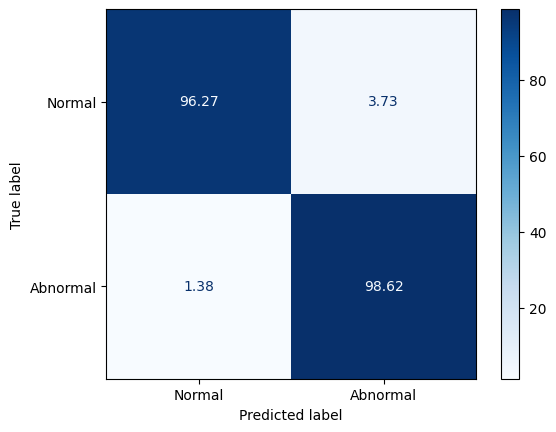

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary, y_train_binary)

# 2. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (Decision Tree with SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 7. Classification Report 출력
print("\nClassification Report (Decision Tree with SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()



Classification Report (Decision Tree with SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       113
           1       0.16      0.27      0.20        22
           2       0.33      0.51      0.40       502
           3       0.89      0.80      0.84      4296
           4       0.90      0.92      0.91       453
           5       1.00      0.99      0.99     11591
           6       0.48      0.65      0.55       441
           7       0.21      0.33      0.26        30

    accuracy                           0.92     17448
   macro avg       0.58      0.65      0.61     17448
weighted avg       0.93      0.92      0.92     17448



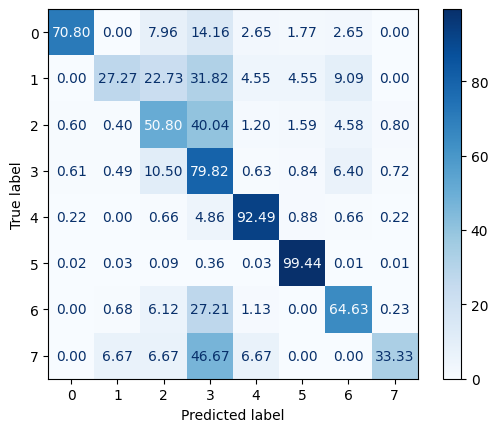

In [ ]:
# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# 2. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 3. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. Classification Report 출력
print("\nClassification Report (Decision Tree with SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###4. 특성 추출 + 클래스 불균형

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Importance + SMOTE - Binary Classification):
Accuracy: 0.9805
Recall: 0.9866
Precision: 0.9873
F1-Score: 0.9870
Time to Train: 1.7806 seconds
Time to Predict: 0.0033 seconds

Classification Report (Decision Tree with Feature Importance + SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.97      0.97     23271
weighted avg       0.98      0.98      0.98     23271



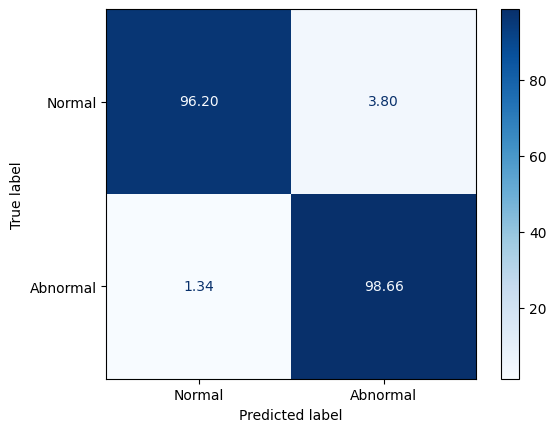

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_binary, y_train_binary)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_binary_reduced = selector.transform(X_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary_reduced, y_train_binary)

# 3. 모델 초기화
decision_tree_binary = DecisionTreeClassifier(random_state=42)

# 4. 모델 훈련
start_train = time.time()
decision_tree_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_binary = decision_tree_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("Performance Metrics (Decision Tree with Feature Importance + SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Importance + SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Performance Metrics (Decision Tree with Feature Selection + SMOTE - Multi-class):
Accuracy: 0.8678
Recall: 0.8678
Precision: 0.8938
F1-Score: 0.8790
Time to Train: 13.0521 seconds
Time to Predict: 0.0061 seconds

Classification Report (Decision Tree with Feature Selection + SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       113
           1       0.00      0.00      0.00        22
           2       0.15      0.27      0.20       502
           3       0.83      0.71      0.77      4296
           4       0.64      0.71      0.67       453
           5       0.99      0.98      0.99     11591
           6       0.26      0.35      0.30       441
           7       0.01      0.03      0.02        30

    accuracy                           0.87     17448
   macro avg       0.44      0.46      0.44     17448
weighted avg       0.89      0.87      0.88     17448



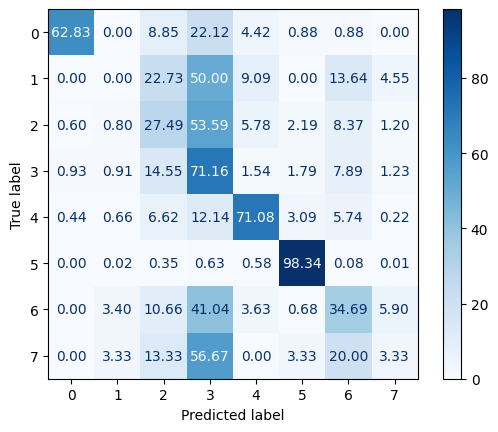

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi_reduced, y_train_multi)

# 3. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 4. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("Performance Metrics (Decision Tree with Feature Selection + SMOTE - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Selection + SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected top-20 features based on Decision Tree importance.
Performance Metrics (Decision Tree with Feature Importance + SMOTE - Multi-class):
Accuracy: 0.9141
Recall: 0.9141
Precision: 0.9282
F1-Score: 0.9196
Time to Train: 30.1111 seconds
Time to Predict: 0.0050 seconds

Classification Report (Decision Tree with Feature Importance + SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       113
           1       0.21      0.45      0.29        22
           2       0.32      0.48      0.38       502
           3       0.88      0.79      0.84      4296
           4       0.86      0.91      0.88       453
           5       1.00      0.99      0.99     11591
           6       0.46      0.63      0.54       441
           7       0.29      0.40      0.34        30

    accuracy                           0.91     17448
   macro avg       0.60      0.68      0.62     17448
weighted avg       0.93      0.91      0.92  

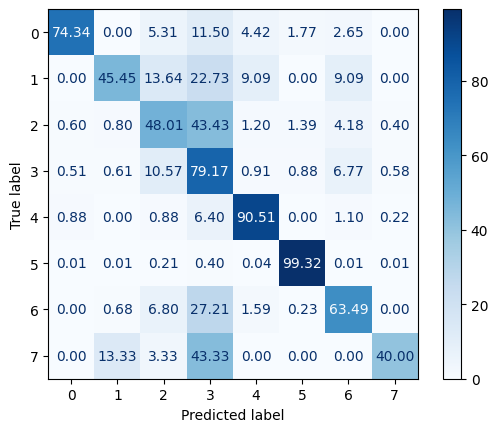

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 중요도 기반 선택
# 결정트리 모델로 특성 중요도 계산
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train_multi, y_train_multi)  # 전체 데이터로 훈련
importances = base_tree.feature_importances_

# 상위 k개의 특성 선택
k = 20
threshold = sorted(importances, reverse=True)[k-1]  # 상위 k번째 중요도 값
selector = SelectFromModel(base_tree, prefit=True, threshold=threshold)
X_train_multi_reduced = selector.transform(X_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

print(f"Selected top-{k} features based on Decision Tree importance.")

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi_reduced, y_train_multi)

# 3. 모델 초기화
decision_tree_multi = DecisionTreeClassifier(random_state=42)

# 4. 모델 훈련
start_train = time.time()
decision_tree_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_multi = decision_tree_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("Performance Metrics (Decision Tree with Feature Importance + SMOTE - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree with Feature Importance + SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###5. 하이퍼파라미터 튜닝

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.9881713580851207

Performance Metrics (Decision Tree - Binary Classification):
Accuracy: 0.9829
Recall: 0.9866
Precision: 0.9905
F1-Score: 0.9886
Time to Train: 20.6467 seconds
Time to Predict: 0.0120 seconds

Classification Report (Decision Tree - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



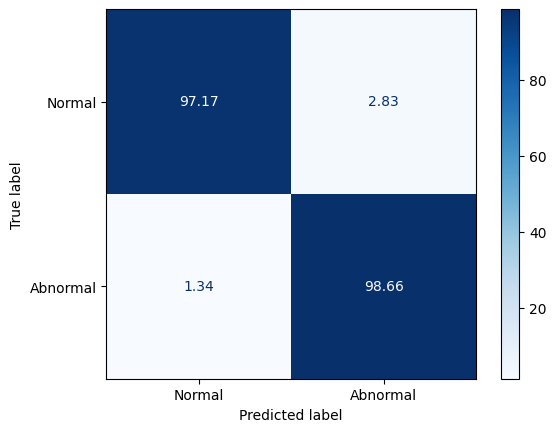

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1',  # 이진분류에서 F1 점수를 기준으로 최적화
    cv=3,  # 교차 검증 폴드 수
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_binary = best_model.predict(X_test_binary)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("\nPerformance Metrics (Decision Tree - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'criterion': 'gini'}
Best score: 0.9371660652479678

Performance Metrics (Decision Tree - Multi-class):
Accuracy: 0.9410
Recall: 0.9410
Precision: 0.9362
F1-Score: 0.9367
Time to Train: 17.4327 seconds
Time to Predict: 0.0121 seconds

Classification Report (Decision Tree - Multi-class):
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       113
           1       0.00      0.00      0.00        22
           2       0.59      0.29      0.39       502
           3       0.86      0.93      0.89      4296
           4       0.95      0.87      0.91       453
           5       1.00      0.99      1.00     11591
           6       0.61      0.56      0.58       441
           7       0.50      0.63      0.56        30

    accuracy                           0.94     17448
   m

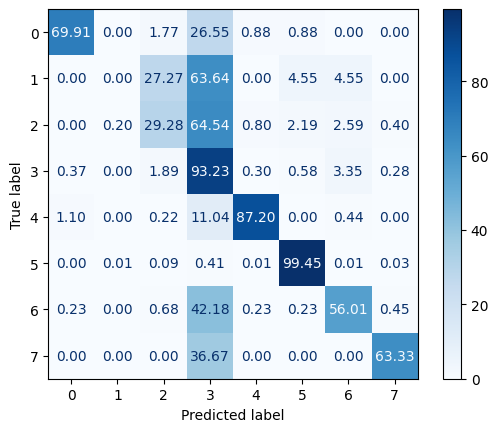

In [ ]:
# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1_weighted',  # 다중분류에서 weighted F1 점수를 기준으로 최적화
    cv=3,
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_multi = best_model.predict(X_test_multi)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("\nPerformance Metrics (Decision Tree - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (Decision Tree - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

##XGBoost

###1.기본

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:53:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics:
Accuracy: 0.9852
Recall: 0.9891
Precision: 0.9912
F1-Score: 0.9901
Time to Train: 2.1700 seconds
Time to Predict: 0.0693 seconds

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.99     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.99      0.99      0.99     23271



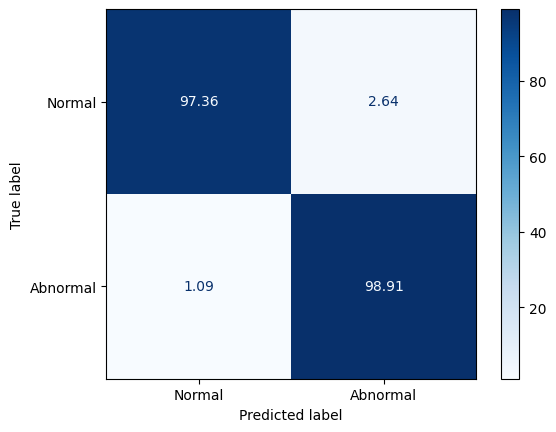

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 1. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 4. 성능 기록
performance_data.append({
    "Model": "XGBoost",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost - Multi-class):
Accuracy: 0.9485
Recall: 0.9485
Precision: 0.9469
F1-Score: 0.9451
Time to Train: 59.5143 seconds
Time to Predict: 0.4708 seconds

Classification Report (XGBoost - Multi-class):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       113
           1       0.90      0.41      0.56        22
           2       0.75      0.35      0.48       502
           3       0.87      0.94      0.91      4296
           4       0.96      0.94      0.95       453
           5       1.00      1.00      1.00     11591
           6       0.58      0.59      0.58       441
           7       0.45      0.30      0.36        30

    accuracy                           0.95     17448
   macro avg       0.80      0.67      0.71     17448
weighted avg       0.95      0.95      0.95     17448



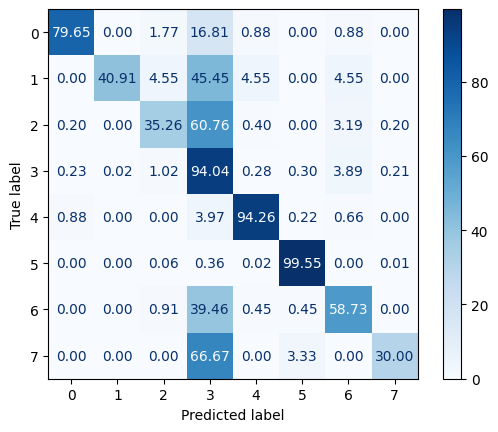

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 1. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 2. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi)
end_predict = time.time()

# 3. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 4. 성능 기록
performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 5. 성능 출력
print("Performance Metrics (XGBoost - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 6. Classification Report 출력
print("\nClassification Report (XGBoost - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###2. 특성 추출

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection - Binary Classification):
Accuracy: 0.9819
Recall: 0.9870
Precision: 0.9887
F1-Score: 0.9879
Time to Train: 6.4282 seconds
Time to Predict: 0.0475 seconds

Classification Report (XGBoost with Feature Selection - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.96      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



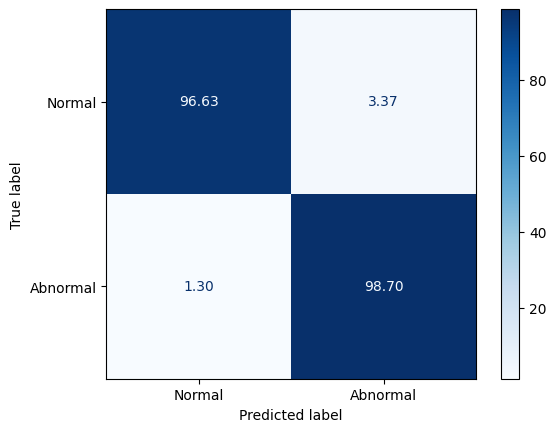

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_binary_reduced = selector.fit_transform(X_train_binary, y_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

# 2. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_reduced, y_train_binary)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")



# 7. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:52:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection - Multi-class):
Accuracy: 0.9214
Recall: 0.9214
Precision: 0.9033
F1-Score: 0.9053
Time to Train: 24.8133 seconds
Time to Predict: 0.6387 seconds

Classification Report (XGBoost with Feature Selection - Multi-class):
              precision    recall  f1-score   support

           0       0.84      0.64      0.72       113
           1       0.00      0.00      0.00        22
           2       0.39      0.07      0.12       502
           3       0.79      0.96      0.87      4296
           4       0.77      0.72      0.75       453
           5       1.00      0.99      0.99     11591
           6       0.34      0.10      0.16       441
           7       0.00      0.00      0.00        30

    accuracy                           0.92     17448
   macro avg       0.52      0.44      0.45     17448
weighted avg       0.90      0.92      0.91     17448



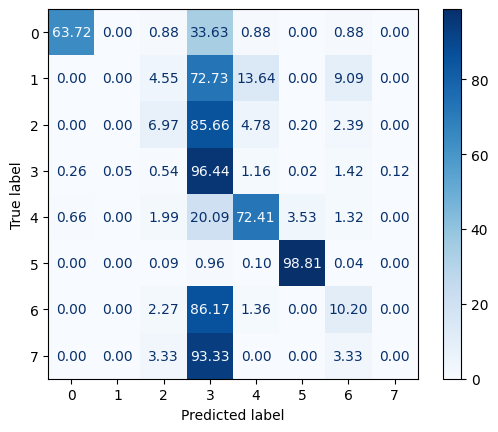

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_reduced, y_train_multi)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

performance_data.append({
    "Model": "XGBoost",
    "Type": "Multi-class",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})
# 7. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###3. 클래스 불균형 해결

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:01:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with SMOTE - Binary Classification):
Accuracy: 0.9847
Recall: 0.9877
Precision: 0.9918
F1-Score: 0.9897
Time to Train: 7.1707 seconds
Time to Predict: 0.0728 seconds

Classification Report (XGBoost with SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



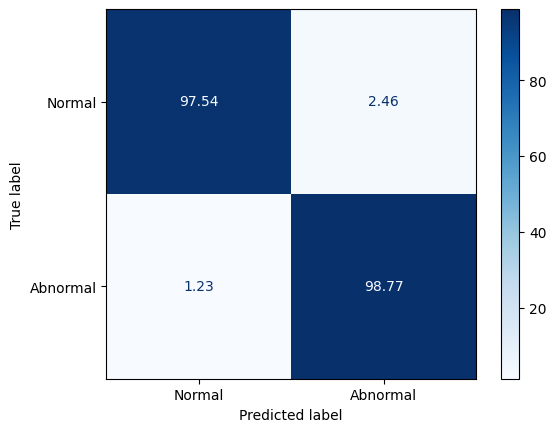

In [ ]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary, y_train_binary)

# 2. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 6. 성능 출력
print("Performance Metrics (XGBoost with SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 7. Classification Report 출력
print("\nClassification Report (XGBoost with SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 8. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:02:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report (XGBoost with SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       113
           1       0.33      0.50      0.40        22
           2       0.45      0.55      0.49       502
           3       0.91      0.83      0.87      4296
           4       0.94      0.94      0.94       453
           5       1.00      0.99      1.00     11591
           6       0.49      0.81      0.61       441
           7       0.37      0.50      0.42        30

    accuracy                           0.93     17448
   macro avg       0.65      0.74      0.69     17448
weighted avg       0.94      0.93      0.94     17448



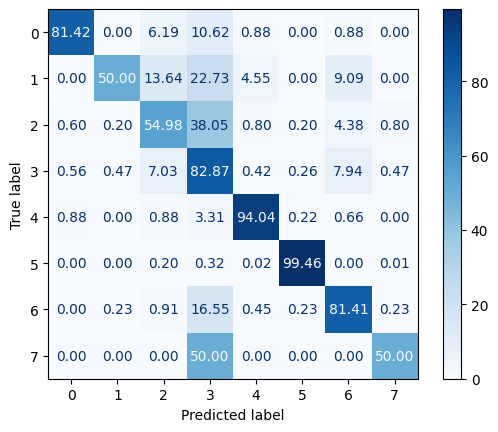

In [ ]:
# 1. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi, y_train_multi)

# 2. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 4. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi)
end_predict = time.time()

# 5. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 6. Classification Report 출력
print("\nClassification Report (XGBoost with SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 7. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###4. 특성 추출 + 클래스 불균형

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection + SMOTE - Binary Classification):
Accuracy: 0.9810
Recall: 0.9806
Precision: 0.9940
F1-Score: 0.9873
Time to Train: 1.5168 seconds
Time to Predict: 0.0467 seconds

Classification Report (XGBoost with Feature Selection + SMOTE - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96      5823
    Abnormal       0.99      0.98      0.99     17448

    accuracy                           0.98     23271
   macro avg       0.97      0.98      0.98     23271
weighted avg       0.98      0.98      0.98     23271



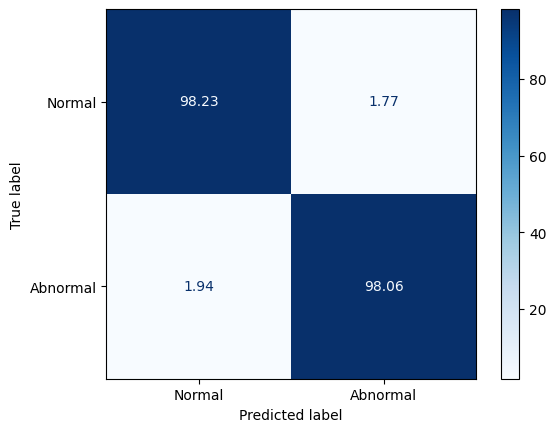

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_binary_reduced = selector.fit_transform(X_train_binary, y_train_binary)
X_test_binary_reduced = selector.transform(X_test_binary)

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_binary_resampled, y_train_binary_resampled = smote.fit_resample(X_train_binary_reduced, y_train_binary)

# 3. 모델 초기화
xgb_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 4. 모델 훈련
start_train = time.time()
xgb_binary.fit(X_train_binary_resampled, y_train_binary_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_binary = xgb_binary.predict(X_test_binary_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection + SMOTE - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection + SMOTE - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [38] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:03:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Performance Metrics (XGBoost with Feature Selection + SMOTE - Multi-class):
Accuracy: 0.8601
Recall: 0.8601
Precision: 0.9142
F1-Score: 0.8797
Time to Train: 46.9256 seconds
Time to Predict: 0.2808 seconds

Classification Report (XGBoost with Feature Selection + SMOTE - Multi-class):
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       113
           1       0.00      0.00      0.00        22
           2       0.20      0.36      0.25       502
           3       0.88      0.64      0.74      4296
           4       0.65      0.76      0.70       453
           5       1.00      0.98      0.99     11591
           6       0.27      0.60      0.37       441
           7       0.01      0.07      0.02        30

    accuracy                           0.86     17448
   macro avg       0.45      0.52      0.46     17448
weighted avg       0.91      0.86      0.88     17448



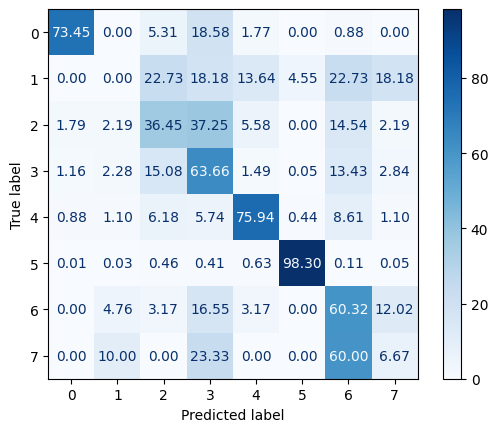

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
import matplotlib.pyplot as plt

# 1. 특성 추출 (SelectKBest)
k = 20  # 선택할 특성의 개수
selector = SelectKBest(score_func=f_classif, k=k)
X_train_multi_reduced = selector.fit_transform(X_train_multi, y_train_multi)
X_test_multi_reduced = selector.transform(X_test_multi)

# 2. 클래스 불균형 처리 (SMOTE)
smote = SMOTE(random_state=42)
X_train_multi_resampled, y_train_multi_resampled = smote.fit_resample(X_train_multi_reduced, y_train_multi)

# 3. 모델 초기화
xgb_multi = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 4. 모델 훈련
start_train = time.time()
xgb_multi.fit(X_train_multi_resampled, y_train_multi_resampled)
end_train = time.time()

# 5. 예측
start_predict = time.time()
y_pred_multi = xgb_multi.predict(X_test_multi_reduced)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("Performance Metrics (XGBoost with Feature Selection + SMOTE - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (XGBoost with Feature Selection + SMOTE - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


###5. 하이퍼파라미터 튜닝

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:04:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters: {'subsample': 0.8, 'reg_lambda': 50, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score: 0.9895336921107108

Performance Metrics (XGBoost - Binary Classification):
Accuracy: 0.9854
Recall: 0.9900
Precision: 0.9905
F1-Score: 0.9903
Time to Train: 239.1869 seconds
Time to Predict: 0.2052 seconds

Classification Report (XGBoost - Binary Classification):
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      5823
    Abnormal       0.99      0.99      0.99     17448

    accuracy                           0.99     23271
   macro avg       0.98      0.98      0.98     23271
weighted avg       0.99      0.99      0.99     23271



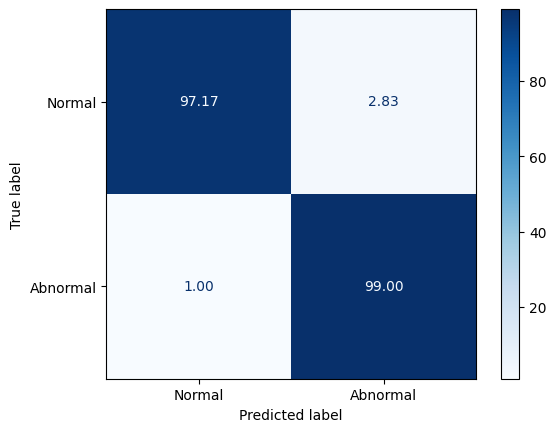

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt

# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 50, 100]
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False,
                            eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1',  # 이진분류에서 F1 점수를 기준으로 최적화
    cv=3,  # 교차 검증 folds
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_binary, y_train_binary)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_binary = best_model.predict(X_test_binary)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary)

# 7. 성능 출력
print("\nPerformance Metrics (XGBoost - Binary Classification):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (XGBoost - Binary Classification):")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Abnormal"]))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# 행 단위로 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:50:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:50:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:51:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:51:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:52:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best parameters: {'subsample': 1.0, 'reg_lambda': 100, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score: 0.9403987098795955

Performance Metrics (XGBoost - Multi-class):
Accuracy: 0.9461
Recall: 0.9461
Precision: 0.9438
F1-Score: 0.9420
Time to Train: 874.5978 seconds
Time to Predict: 0.3059 seconds

Classification Report (XGBoost - Multi-class):
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       113
           1       1.00      0.18      0.31        22
           2       0.70      0.30      0.42       502
           3       0.87      0.94      0.90      4296
           4       0.95      0.93      0.94       453
           5       1.00      0.99      1.00     11591
           6       0.59      0.58      0.59       441
           7       0.52      0.57      0.54        30

    accuracy                           0.95     17448
   macro avg       0.80      0.66      0.69    

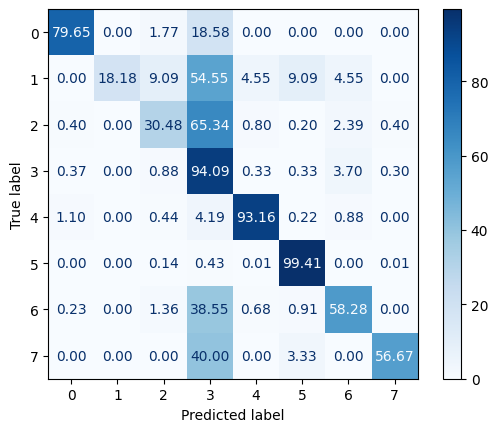

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt
# 1. 하이퍼파라미터 범위 설정
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 50, 100]
}

# 2. RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # 샘플링 횟수
    scoring='f1_weighted',  # 다중분류에서 weighted F1 점수를 기준으로 최적화
    cv=3,
    verbose=1,
    random_state=42
)

# 3. 모델 훈련 (RandomizedSearchCV로 최적 하이퍼파라미터 찾기)
start_train = time.time()
random_search.fit(X_train_multi, y_train_multi)
end_train = time.time()

# 4. 최적 하이퍼파라미터 출력
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# 5. 최적 모델로 테스트 데이터 예측
best_model = random_search.best_estimator_
start_predict = time.time()
y_pred_multi = best_model.predict(X_test_multi)
end_predict = time.time()

# 6. 성능 평가
accuracy = accuracy_score(y_test_multi, y_pred_multi)
recall = recall_score(y_test_multi, y_pred_multi, average='weighted')
precision = precision_score(y_test_multi, y_pred_multi, average='weighted')
f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')

# 7. 성능 출력
print("\nPerformance Metrics (XGBoost - Multi-class):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Time to Train: {end_train - start_train:.4f} seconds")
print(f"Time to Predict: {end_predict - start_predict:.4f} seconds")

# 8. Classification Report 출력
print("\nClassification Report (XGBoost - Multi-class):")
print(classification_report(y_test_multi, y_pred_multi))

# 9. 혼동행렬 시각화
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test_multi, y_pred_multi)

# 행 단위 정규화 (비율 계산)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# 비율 기반 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # 소수점 2자리까지 표시
plt.show()


##CNN

###0. 이진분류

Original dataset shape: {0: 23290, 1: 69791}
Resampled dataset shape: {0: 69791, 1: 69791}
Reshaping data into shape: (1, 1, 56)
Epoch 1: Train Loss: 0.1514, Train Acc: 0.9477, Val Loss: 0.0972, Val Acc: 0.9725
Epoch 2: Train Loss: 0.0957, Train Acc: 0.9645, Val Loss: 0.1019, Val Acc: 0.9622
Epoch 3: Train Loss: 0.0828, Train Acc: 0.9684, Val Loss: 0.0771, Val Acc: 0.9719
Epoch 4: Train Loss: 0.0762, Train Acc: 0.9706, Val Loss: 0.0670, Val Acc: 0.9731
Epoch 5: Train Loss: 0.0723, Train Acc: 0.9713, Val Loss: 0.0703, Val Acc: 0.9712
Epoch 6: Train Loss: 0.0664, Train Acc: 0.9741, Val Loss: 0.0607, Val Acc: 0.9751
Epoch 7: Train Loss: 0.0651, Train Acc: 0.9741, Val Loss: 0.0685, Val Acc: 0.9710
Epoch 8: Train Loss: 0.0639, Train Acc: 0.9749, Val Loss: 0.0645, Val Acc: 0.9722
Epoch 9: Train Loss: 0.0630, Train Acc: 0.9749, Val Loss: 0.0600, Val Acc: 0.9742
Epoch 10: Train Loss: 0.0626, Train Acc: 0.9751, Val Loss: 0.0661, Val Acc: 0.9712
Epoch 11: Train Loss: 0.0599, Train Acc: 0.9765, V

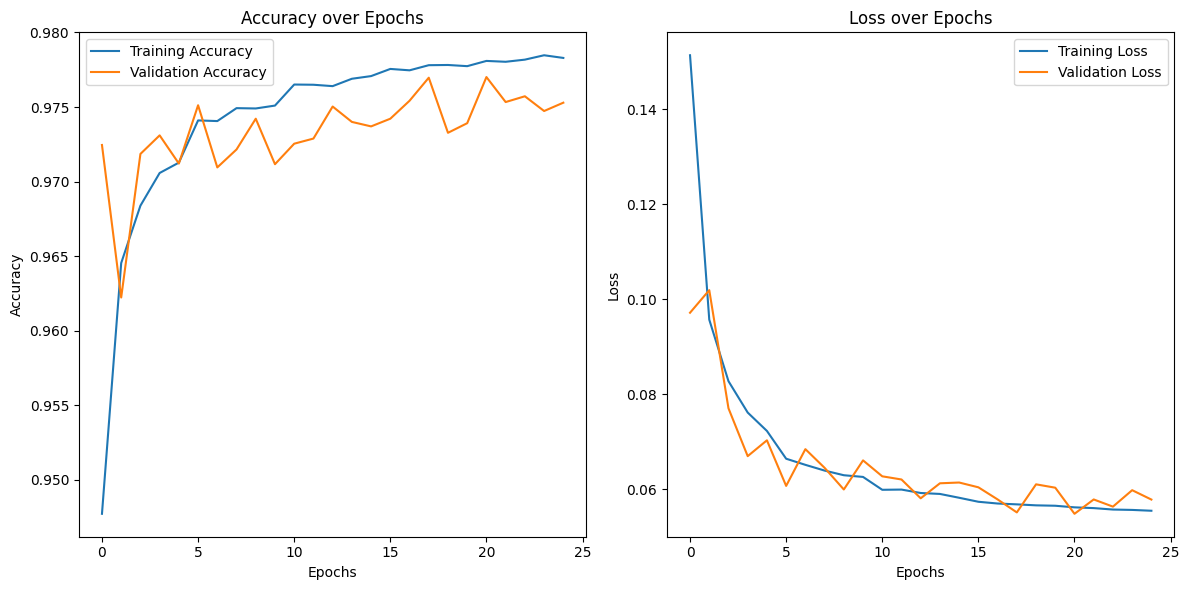

Performance Data:
[{'Model': 'CNN', 'Type': 'Binary', 'Accuracy': 0.9752911348889175, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 3728.1592750549316, 'Time to Predict': 11.338626861572266, 'Total Time': 3739.497901916504}]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import time

# 1. 데이터 준비
X_train = X_train_binary.values
y_train = y_train_binary.values
X_test = X_test_binary.values
y_test = y_test_binary.values

# SMOTE 적용 (이진분류를 위한 데이터 증강)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 데이터의 총 특성 수
num_features = X_resampled.shape[1]

# height와 width를 동적으로 설정
for h in range(1, num_features + 1):  # height를 가능한 값으로 탐색
    if num_features % h == 0:         # 나누어 떨어지는 경우 선택
        height = h
        width = num_features // h
        break

print(f"Reshaping data into shape: (1, {height}, {width})")

# CNN 입력용으로 데이터 변환
X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. CNN 모델 정의
class CNNBinaryClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNNBinaryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout_prob)
        self.flatten_size = None
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, 2).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
dropout_prob = 0.4
model = CNNBinaryClassifier(dropout_prob=dropout_prob)

class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (2 * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.0005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
epochs = 25
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
end_train = time.time()

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
start_predict = time.time()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 6. 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Binary",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###1. 기본

Epoch 1: Train Loss: 0.3823, Train Acc: 0.8931, Val Loss: 0.3007, Val Acc: 0.9044
Epoch 2: Train Loss: 0.2797, Train Acc: 0.9075, Val Loss: 0.2740, Val Acc: 0.9068
Epoch 3: Train Loss: 0.2569, Train Acc: 0.9123, Val Loss: 0.2526, Val Acc: 0.9143
Epoch 4: Train Loss: 0.2440, Train Acc: 0.9166, Val Loss: 0.2412, Val Acc: 0.9191
Epoch 5: Train Loss: 0.2333, Train Acc: 0.9185, Val Loss: 0.2331, Val Acc: 0.9198
Epoch 6: Train Loss: 0.2252, Train Acc: 0.9213, Val Loss: 0.2288, Val Acc: 0.9197
Epoch 7: Train Loss: 0.2197, Train Acc: 0.9223, Val Loss: 0.2246, Val Acc: 0.9222
Epoch 8: Train Loss: 0.2148, Train Acc: 0.9237, Val Loss: 0.2366, Val Acc: 0.9150
Epoch 9: Train Loss: 0.2121, Train Acc: 0.9244, Val Loss: 0.2182, Val Acc: 0.9241
Epoch 10: Train Loss: 0.2086, Train Acc: 0.9251, Val Loss: 0.2146, Val Acc: 0.9245
Epoch 11: Train Loss: 0.2059, Train Acc: 0.9257, Val Loss: 0.2167, Val Acc: 0.9218
Epoch 12: Train Loss: 0.2031, Train Acc: 0.9265, Val Loss: 0.2101, Val Acc: 0.9250
Epoch 13: Tra

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


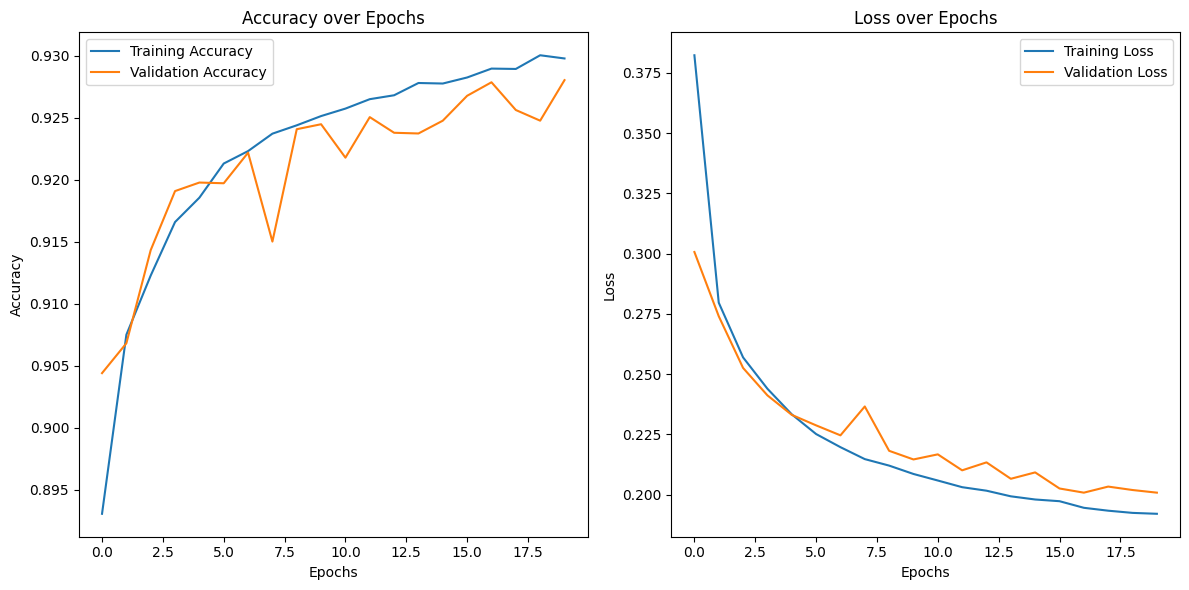

Performance Data:
[{'Model': 'CNN', 'Type': 'Binary', 'Accuracy': 0.9752911348889175, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 3728.1592750549316, 'Time to Predict': 11.338626861572266, 'Total Time': 3739.497901916504}, {'Model': 'CNN', 'Type': 'Multi-class', 'Accuracy': 0.9280146721687299, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 206.48343086242676, 'Time to Predict': 0.9466390609741211, 'Total Time': 207.43006992340088}]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time

# 1. 데이터 준비
# 2D 데이터 형태로 변환 (예: [batch_size, 1, height, width])
height = 8
width = X_train_multi.shape[1] // height

X_train_cnn = X_train_multi.values.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test_multi.values.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_multi.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_multi.values, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(y_train_multi.unique())
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
start_predict = time.time()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_train - start_train:.2f} seconds")

# 6. 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class1",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 학습 결과 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###2. 클래스 불균형 - 클래스 샘플 개수 기반으로 가중치 계산

Epoch 1: Train Loss: 1.3758, Train Acc: 0.8359, Val Loss: 1.1599, Val Acc: 0.8530
Epoch 2: Train Loss: 1.0773, Train Acc: 0.8575, Val Loss: 1.0140, Val Acc: 0.8658
Epoch 3: Train Loss: 0.9703, Train Acc: 0.8588, Val Loss: 1.0578, Val Acc: 0.8415
Epoch 4: Train Loss: 0.9189, Train Acc: 0.8583, Val Loss: 0.9471, Val Acc: 0.8178
Epoch 5: Train Loss: 0.8755, Train Acc: 0.8578, Val Loss: 0.9243, Val Acc: 0.8376
Epoch 6: Train Loss: 0.8554, Train Acc: 0.8580, Val Loss: 0.9113, Val Acc: 0.8529
Epoch 7: Train Loss: 0.8275, Train Acc: 0.8583, Val Loss: 0.8663, Val Acc: 0.8552
Epoch 8: Train Loss: 0.8161, Train Acc: 0.8604, Val Loss: 0.8691, Val Acc: 0.8562
Epoch 9: Train Loss: 0.7963, Train Acc: 0.8594, Val Loss: 0.8624, Val Acc: 0.8514
Epoch 10: Train Loss: 0.7866, Train Acc: 0.8608, Val Loss: 0.8544, Val Acc: 0.8647
Epoch 11: Train Loss: 0.7736, Train Acc: 0.8622, Val Loss: 0.8417, Val Acc: 0.8688
Epoch 12: Train Loss: 0.7534, Train Acc: 0.8627, Val Loss: 0.8220, Val Acc: 0.8549
Epoch 13: Tra

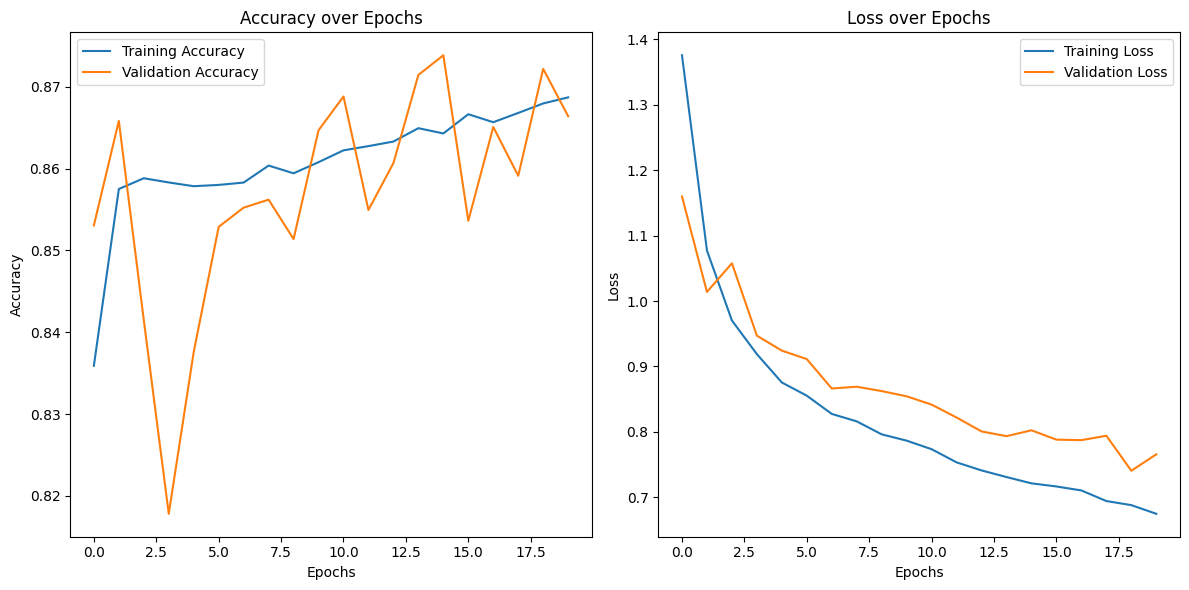

Performance Data:
[{'Model': 'CNN', 'Type': 'Binary', 'Accuracy': 0.9752911348889175, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 3728.1592750549316, 'Time to Predict': 11.338626861572266, 'Total Time': 3739.497901916504}, {'Model': 'CNN', 'Type': 'Multi-class', 'Accuracy': 0.9280146721687299, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 206.48343086242676, 'Time to Predict': 0.9466390609741211, 'Total Time': 207.43006992340088}, {'Model': 'CNN', 'Type': 'Multi-class2', 'Accuracy': 0.8664030261348006, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 230.19812941551208, 'Time to Predict': 0.9555923938751221, 'Total Time': 231.1537218093872}]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import time

# 1. 데이터 준비
height = 8  # 예시로 설정 (가로*세로=특성 수)
width = X_train_multi.shape[1] // height

X_train_cnn = X_train_multi.values.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test_multi.values.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_multi.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_multi.values, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. 클래스 가중치 계산
class_counts = y_train_multi.value_counts().sort_index()
total_samples = len(y_train_multi)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

# 3. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = None

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        if self.fc1 is None:
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 4. 모델 생성 및 학습 설정
num_classes = len(y_train_multi.unique())
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 5. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()

# 6. 성능 평가
start_predict = time.time()
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Training Time: {end_train - start_train:.2f} seconds")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class2",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 7. 학습 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 8. 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###2. 클래스 불균형 - SMOTE

Original dataset shape: {0: 451, 1: 88, 2: 2006, 3: 17184, 4: 1813, 5: 46365, 6: 1766, 7: 118}
Resampled dataset shape: {0: 46365, 1: 46365, 2: 46365, 3: 46365, 4: 46365, 5: 46365, 6: 46365, 7: 46365}
Epoch 1: Train Loss: 0.8014, Train Acc: 0.7311, Val Loss: 0.4155, Val Acc: 0.8557
Epoch 2: Train Loss: 0.5399, Train Acc: 0.8261, Val Loss: 0.3712, Val Acc: 0.8693
Epoch 3: Train Loss: 0.4632, Train Acc: 0.8509, Val Loss: 0.3904, Val Acc: 0.8579
Epoch 4: Train Loss: 0.4187, Train Acc: 0.8638, Val Loss: 0.3387, Val Acc: 0.8760
Epoch 5: Train Loss: 0.3905, Train Acc: 0.8718, Val Loss: 0.3333, Val Acc: 0.8802
Epoch 6: Train Loss: 0.3677, Train Acc: 0.8791, Val Loss: 0.2979, Val Acc: 0.8916
Epoch 7: Train Loss: 0.3504, Train Acc: 0.8842, Val Loss: 0.4045, Val Acc: 0.8483
Epoch 8: Train Loss: 0.3375, Train Acc: 0.8885, Val Loss: 0.2799, Val Acc: 0.8990
Epoch 9: Train Loss: 0.3250, Train Acc: 0.8915, Val Loss: 0.3404, Val Acc: 0.8831
Epoch 10: Train Loss: 0.3152, Train Acc: 0.8950, Val Loss: 0.

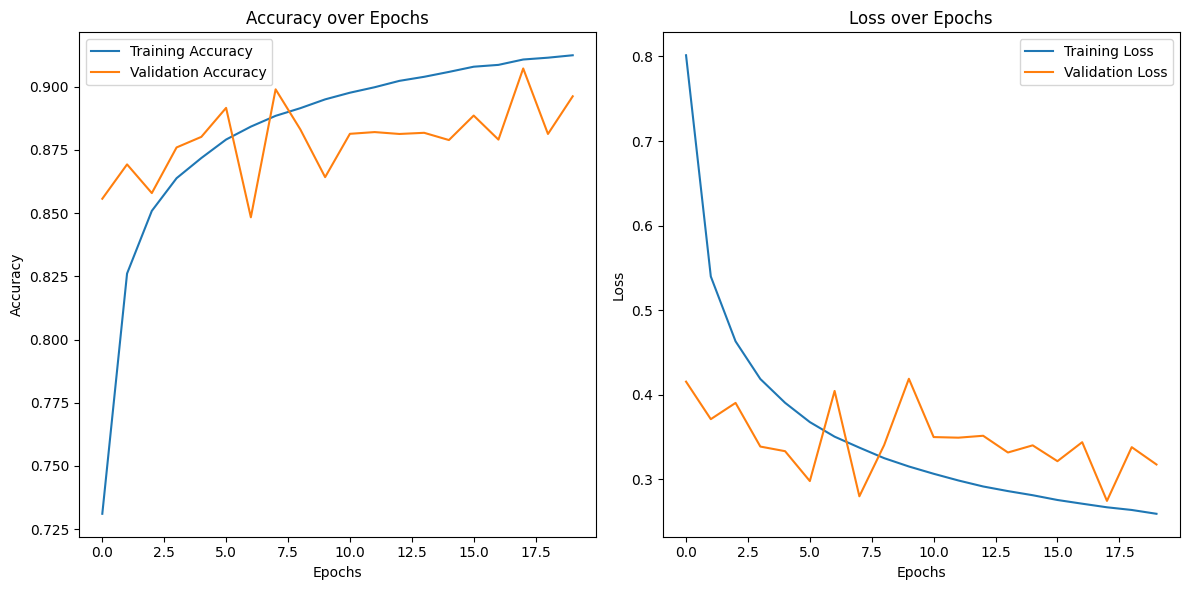

Performance Data:
[{'Model': 'CNN', 'Type': 'Binary', 'Accuracy': 0.9752911348889175, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 3728.1592750549316, 'Time to Predict': 11.338626861572266, 'Total Time': 3739.497901916504}, {'Model': 'CNN', 'Type': 'Multi-class', 'Accuracy': 0.9280146721687299, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 206.48343086242676, 'Time to Predict': 0.9466390609741211, 'Total Time': 207.43006992340088}, {'Model': 'CNN', 'Type': 'Multi-class2', 'Accuracy': 0.8664030261348006, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 230.19812941551208, 'Time to Predict': 0.9555923938751221, 'Total Time': 231.1537218093872}, {'Model': 'CNN', 'Type': 'Multi-class3', 'Accuracy': 0.896205868867492, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 1032.935886144638, 'Time to Predict': 0.9257845878601074, 'Total Time': 1033.8616707324982}]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1 (크기는 forward에서 설정)
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
model = CNNMultiClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. 학습 루프
start_train = time.time()  # 학습 시작 시간
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
end_train = time.time()  # 학습 종료 시간

# 5. 성능 평가
start_predict = time.time()  # 예측 시작 시간
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()  # 예측 종료 시간

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class3",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. 결과 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###3. 하이퍼파라미터 튜닝

Original dataset shape: {0: 451, 1: 88, 2: 2006, 3: 17184, 4: 1813, 5: 46365, 6: 1766, 7: 118}
Resampled dataset shape: {0: 46365, 1: 46365, 2: 46365, 3: 46365, 4: 46365, 5: 46365, 6: 46365, 7: 46365}
Epoch 1: Train Loss: 0.9529, Train Acc: 0.6923, Val Loss: 0.4390, Val Acc: 0.8509
Epoch 2: Train Loss: 0.6941, Train Acc: 0.7788, Val Loss: 0.4690, Val Acc: 0.8234
Epoch 3: Train Loss: 0.6290, Train Acc: 0.7984, Val Loss: 0.4285, Val Acc: 0.8431
Epoch 4: Train Loss: 0.5925, Train Acc: 0.8109, Val Loss: 0.3763, Val Acc: 0.8534
Epoch 5: Train Loss: 0.5686, Train Acc: 0.8172, Val Loss: 0.4038, Val Acc: 0.8466
Epoch 6: Train Loss: 0.5172, Train Acc: 0.8354, Val Loss: 0.3519, Val Acc: 0.8706
Epoch 7: Train Loss: 0.5086, Train Acc: 0.8387, Val Loss: 0.3519, Val Acc: 0.8721
Epoch 8: Train Loss: 0.5067, Train Acc: 0.8396, Val Loss: 0.4061, Val Acc: 0.8569
Epoch 9: Train Loss: 0.5021, Train Acc: 0.8411, Val Loss: 0.3628, Val Acc: 0.8658
Epoch 10: Train Loss: 0.5010, Train Acc: 0.8420, Val Loss: 0.

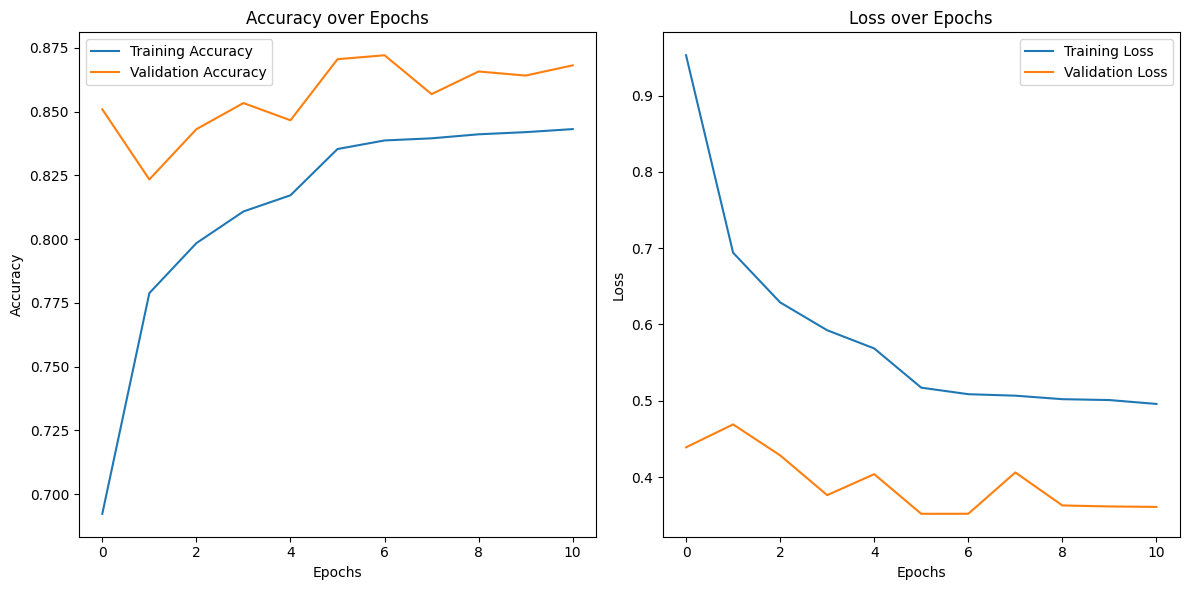

Performance Data:
[{'Model': 'CNN', 'Type': 'Binary', 'Accuracy': 0.9752911348889175, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 3728.1592750549316, 'Time to Predict': 11.338626861572266, 'Total Time': 3739.497901916504}, {'Model': 'CNN', 'Type': 'Multi-class', 'Accuracy': 0.9280146721687299, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 206.48343086242676, 'Time to Predict': 0.9466390609741211, 'Total Time': 207.43006992340088}, {'Model': 'CNN', 'Type': 'Multi-class2', 'Accuracy': 0.8664030261348006, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 230.19812941551208, 'Time to Predict': 0.9555923938751221, 'Total Time': 231.1537218093872}, {'Model': 'CNN', 'Type': 'Multi-class3', 'Accuracy': 0.896205868867492, 'Recall': None, 'Precision': None, 'F1-Score': None, 'Time to Train': 1032.935886144638, 'Time to Predict': 0.9257845878601074, 'Total Time': 1033.8616707324982}, {'Model': 'CNN', 'Type': 'Multi-class4', 'Ac

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pooling
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
model = CNNMultiClassifier(num_classes)

# 클래스 가중치 계산
class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 적용
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # 학습률 스케줄러 추가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_train = time.time()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
end_train = time.time()

# 5. 성능 평가
start_predict = time.time()
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class4",
    "Accuracy": accuracy,
    "Recall": None,
    "Precision": None,
    "F1-Score": None,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 데이터 출력
print("Performance Data:")
print(performance_data)

###4. 불균형 해결 + 하이퍼파라미터 튜닝

Original dataset shape: {0: 451, 1: 88, 2: 2006, 3: 17184, 4: 1813, 5: 46365, 6: 1766, 7: 118}
Resampled dataset shape: {0: 46365, 1: 46365, 2: 46365, 3: 46365, 4: 46365, 5: 46365, 6: 46365, 7: 46365}
Epoch 1: Train Loss: 1.0426, Train Acc: 0.6740, Val Loss: 0.4378, Val Acc: 0.8574
Epoch 2: Train Loss: 0.7349, Train Acc: 0.7752, Val Loss: 0.4204, Val Acc: 0.8593
Epoch 3: Train Loss: 0.6463, Train Acc: 0.7992, Val Loss: 0.3735, Val Acc: 0.8751
Epoch 4: Train Loss: 0.5962, Train Acc: 0.8140, Val Loss: 0.4197, Val Acc: 0.8591
Epoch 5: Train Loss: 0.5637, Train Acc: 0.8223, Val Loss: 0.3826, Val Acc: 0.8690
Epoch 6: Train Loss: 0.5275, Train Acc: 0.8339, Val Loss: 0.3626, Val Acc: 0.8687
Epoch 7: Train Loss: 0.5159, Train Acc: 0.8380, Val Loss: 0.3398, Val Acc: 0.8765
Epoch 8: Train Loss: 0.5063, Train Acc: 0.8401, Val Loss: 0.3316, Val Acc: 0.8749
Epoch 9: Train Loss: 0.4972, Train Acc: 0.8433, Val Loss: 0.3550, Val Acc: 0.8645
Epoch 10: Train Loss: 0.4903, Train Acc: 0.8456, Val Loss: 0.

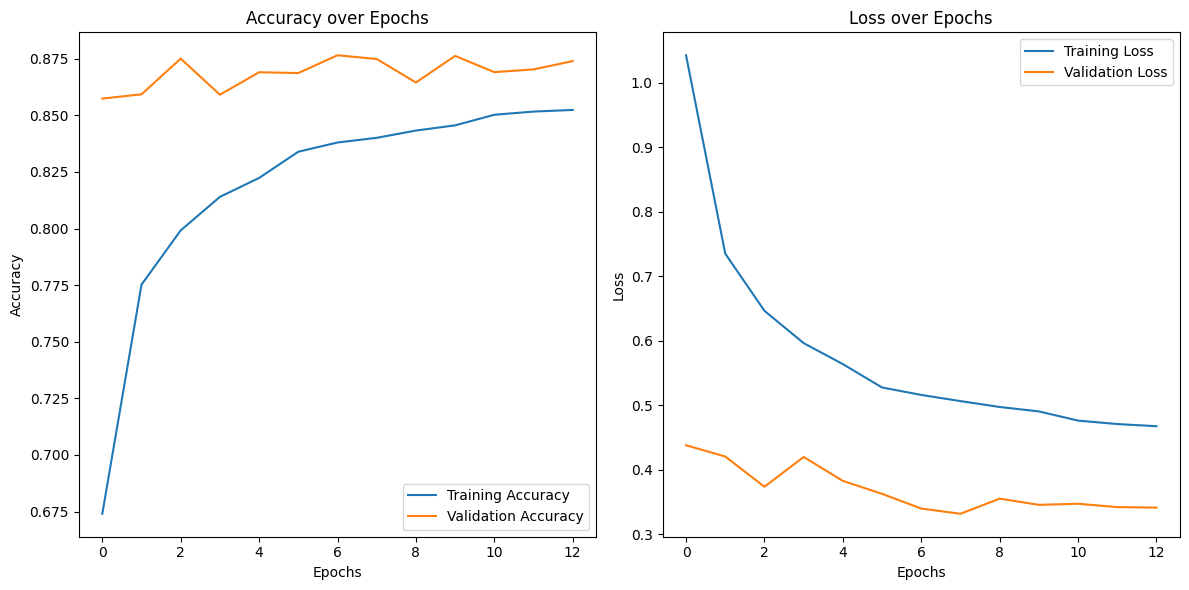

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
X_train = X_train_multi.values
y_train = y_train_multi.values
X_test = X_test_multi.values
y_test = y_test_multi.values

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Resampled dataset shape:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 2D 데이터 변환 (CNN 입력용)
height = 8
width = X_resampled.shape[1] // height

X_resampled = X_resampled.reshape(-1, 1, height, width).astype('float32')
X_test_cnn = X_test.reshape(-1, 1, height, width).astype('float32')

# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader 생성
batch_size = 128  # 배치 크기 조정
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. CNN 모델 정의
class CNNMultiClassifier(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CNNMultiClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max Pooling
        self.dropout = nn.Dropout(dropout_prob)  # 드롭아웃 추가
        self.flatten_size = None  # Flatten 크기 계산
        self.fc1 = None  # Fully Connected Layer 1
        self.fc2 = None  # Fully Connected Layer 2

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Conv1 -> BN -> ReLU -> Pooling
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Conv2 -> BN -> ReLU -> Pooling
        if self.fc1 is None:  # 첫 forward 호출 시 동적으로 Fully Connected Layer 생성
            self.flatten_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
            self.fc2 = nn.Linear(128, num_classes).to(x.device)
        x = x.view(-1, self.flatten_size)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc2(x)
        return x

# 3. 모델 생성 및 학습 설정
num_classes = len(np.unique(y_train))
dropout_prob = 0.4  # 드롭아웃 확률 조정
model = CNNMultiClassifier(num_classes, dropout_prob=dropout_prob)

# 클래스 가중치 계산
class_counts = np.bincount(y_resampled)
class_weights = len(y_resampled) / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 적용
learning_rate = 0.0005  # 학습률 조정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # 학습률 스케줄러 추가
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 조기 종료 설정
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# 4. 학습 루프
# 모델 학습 시작 시간
start_train = time.time()

epochs = 25  # 에포크 수 증가
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 조기 종료 조건 확인
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# 학습 종료 시간
end_train = time.time()

# 성능 평가 시작 시간
start_predict = time.time()

# 5. 성능 평가
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 성능 평가 종료 시간
end_predict = time.time()

# 성능 출력
accuracy = accuracy_score(y_true, y_pred)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print(f"Test Accuracy: {accuracy:.4f}")

# 성능 데이터 저장
performance_data.append({
    "Model": "CNN",
    "Type": "Multi-class4",
    "Accuracy": accuracy,
    "Recall": recall,
    "Precision": precision,
    "F1-Score": f1,
    "Time to Train": end_train - start_train,
    "Time to Predict": end_predict - start_predict,
    "Total Time": (end_train - start_train) + (end_predict - start_predict)
})

# 6. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


##성능 비교

In [ ]:
# performance_data가 리스트일 경우, DataFrame으로 변환
performance_df = pd.DataFrame(performance_data)

# 성능 데이터프레임 스타일링
styled_table = performance_df.style.background_gradient(cmap="coolwarm", subset=["Accuracy", "Time to Train", "Total Time"]) \
    .format({"Accuracy": "{:.4%}", "Time to Train": "{:.2f}", "Total Time": "{:.2f}"}) \
    .set_caption("Model Performance Summary")

# 테이블 출력
styled_table

,Model,Type,Accuracy,Recall,Precision,F1-Score,Time to Train,Time to Predict,Total Time
0,CNN,Binary,97.5291%,nan,nan,nan,3728.16,11.338627,3739.50
1,CNN,Multi-class,92.8015%,nan,nan,nan,206.48,0.946639,207.43
2,CNN,Multi-class2,86.6403%,nan,nan,nan,230.20,0.955592,231.15
3,CNN,Multi-class3,89.6206%,nan,nan,nan,1032.94,0.925785,1033.86
4,CNN,Multi-class4,86.8180%,nan,nan,nan,703.40,1.000600,704.40
5,CNN,Multi-class4,87.3968%,0.868180,0.935947,0.886351,720.37,1.581217,721.95


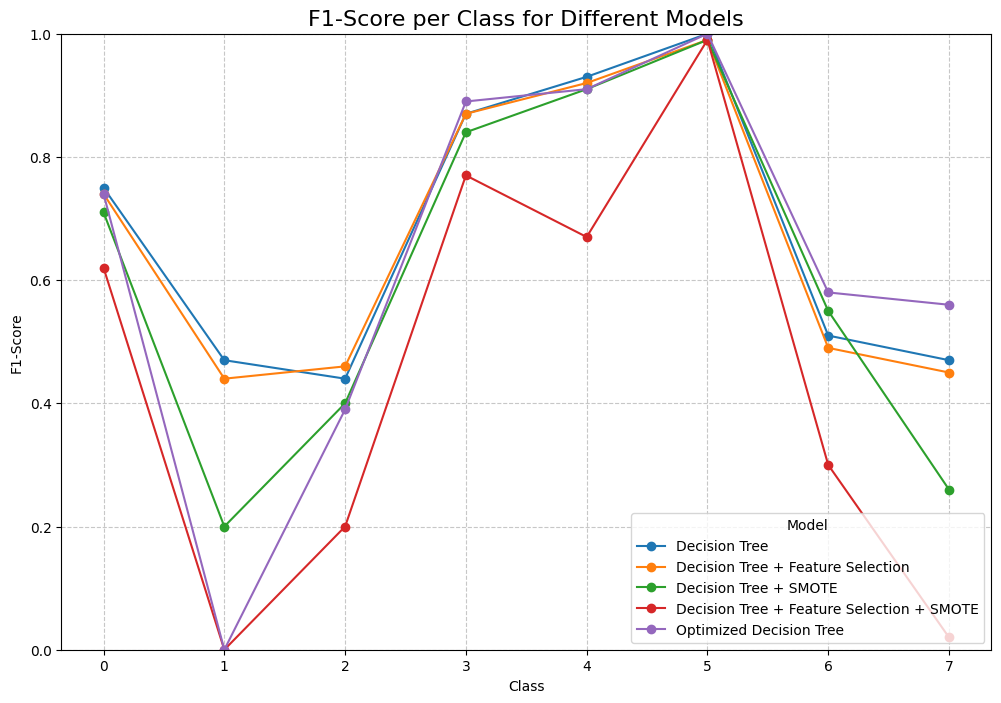

In [ ]:
# F1-score 데이터를 준비
classes = ["0", "1", "2", "3", "4", "5", "6", "7"]

# 모델별 F1-score (각 클래스별)
f1_scores = {
    "Decision Tree": [0.75, 0.47, 0.44, 0.87, 0.93, 1.00, 0.51, 0.47],
    "Decision Tree + Feature Selection": [0.74, 0.44, 0.46, 0.87, 0.92, 0.99, 0.49, 0.45],
    "Decision Tree + SMOTE": [0.71, 0.20, 0.40, 0.84, 0.91, 0.99, 0.55, 0.26],
    "Decision Tree + Feature Selection + SMOTE": [0.62, 0.00, 0.20, 0.77, 0.67, 0.99, 0.30, 0.02],
    "Optimized Decision Tree": [0.74, 0.00, 0.39, 0.89, 0.91, 1.00, 0.58, 0.56],
}

# 선 그래프 시각화
plt.figure(figsize=(12, 8))
for model, scores in f1_scores.items():
    plt.plot(classes, scores, label=model, marker='o')

plt.title("F1-Score per Class for Different Models", fontsize=16)
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.legend(title="Model", loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


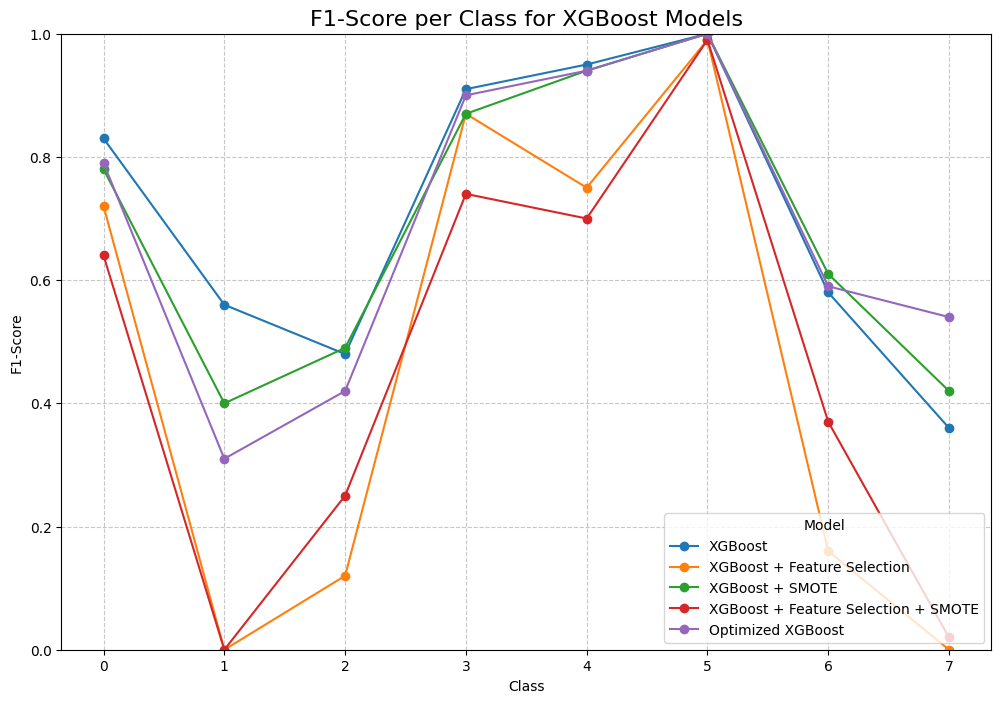

In [ ]:
# XGBoost F1-scores for all configurations
xgb_f1_scores = {
    "XGBoost": [0.83, 0.56, 0.48, 0.91, 0.95, 1.00, 0.58, 0.36],
    "XGBoost + Feature Selection": [0.72, 0.00, 0.12, 0.87, 0.75, 0.99, 0.16, 0.00],
    "XGBoost + SMOTE": [0.78, 0.40, 0.49, 0.87, 0.94, 1.00, 0.61, 0.42],
    "XGBoost + Feature Selection + SMOTE": [0.64, 0.00, 0.25, 0.74, 0.70, 0.99, 0.37, 0.02],
    "Optimized XGBoost": [0.79, 0.31, 0.42, 0.90, 0.94, 1.00, 0.59, 0.54],
}

# X-axis (classes)
xgb_classes = ["0", "1", "2", "3", "4", "5", "6", "7"]

# Line graph for XGBoost F1-scores
plt.figure(figsize=(12, 8))
for model, scores in xgb_f1_scores.items():
    plt.plot(xgb_classes, scores, label=model, marker='o')

plt.title("F1-Score per Class for XGBoost Models", fontsize=16)
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.legend(title="Model", loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
